# 04 — Hypothesis H1: Texture & Color Variability (GLCM)

**Objective**  
Quantify texture differences between healthy and mildew-infected cherry leaves using GLCM features to test H1:
> Mildew-infected leaves exhibit higher texture and color variability than healthy leaves.

**Inputs**  
- Image dataset: `inputs/cherry_leaves_dataset/{healthy, powdery_mildew}`

**Outputs**  
- CSV: `inputs/features/v1/glcm_features.csv` (per-image GLCM features)  
- CSV: `inputs/features/v1/glcm_stats.csv` (p-values & effect sizes)  
- CSV: `inputs/features/v1/glcm_feature_means.csv` (class-wise means/medians)  
- Plot: `plots/v2/glcm_boxplots.png` (boxplots per feature by class)

**Notes**  
Images are resized to 100×100, converted to grayscale, quantized to fixed gray levels, and GLCM features are averaged across multiple distances and angles.

In [9]:
from pathlib import Path
import sys

def find_project_root(start: Path) -> Path:
    """Walk up until a folder containing 'src' is found, else return start."""
    p = start
    for _ in range(5):
        if (p / "src").exists():
            return p
        p = p.parent
    return start

PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.paths import DATA_DIR, PLOTS_DIR, PROJECT_ROOT

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("PLOTS_DIR:", PLOTS_DIR)

PROJECT_ROOT: C:\Users\ksstr\Documents\Coding\milestone-project-5
DATA_DIR: C:\Users\ksstr\Documents\Coding\milestone-project-5\inputs\cherry_leaves_dataset
PLOTS_DIR: C:\Users\ksstr\Documents\Coding\milestone-project-5\plots\v1


In [10]:
# Configuration and output directories
from pathlib import Path

CLASSES = ("healthy", "powdery_mildew")
ALLOWED = {".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"}

IMG_SIZE = (100, 100)           # (width, height)
GRAY_LEVELS = 32                # quantization levels for GLCM
DISTANCES = [1, 2, 3]           # pixel distances
ANGLES = [0, 0.25, 0.5, 0.75]   # angles in units of pi (0, π/4, π/2, 3π/4)
FEATURES = ["contrast", "energy", "homogeneity", "correlation"]

# Output locations
FEATURES_DIR = Path("inputs") / "features" / "v1"
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

PLOTS_V2_DIR = PLOTS_DIR.parent / "v2"
PLOTS_V2_DIR.mkdir(parents=True, exist_ok=True)

print("FEATURES_DIR:", FEATURES_DIR.resolve())
print("PLOTS_V2_DIR:", PLOTS_V2_DIR.resolve())

FEATURES_DIR: C:\Users\ksstr\Documents\Coding\milestone-project-5\jupyter_notebooks\inputs\features\v1
PLOTS_V2_DIR: C:\Users\ksstr\Documents\Coding\milestone-project-5\plots\v2


In [11]:
# Image loading, grayscale quantization, and GLCM feature computation
import numpy as np
from PIL import Image
from skimage.feature import graycomatrix, graycoprops
from pathlib import Path

def iter_image_paths(base_dir: Path, label: str):
    """Yield file paths of valid images inside a class folder."""
    folder = base_dir / label
    if not folder.exists():
        return
    for p in folder.iterdir():
        if p.is_file() and p.suffix in ALLOWED:
            yield p

def load_gray_quantized(path: Path, size=IMG_SIZE, levels=GRAY_LEVELS) -> np.ndarray:
    """
    Read image, resize to `size`, convert to 8-bit grayscale, then
    uniformly quantize to integer gray levels in [0, levels-1].
    """
    with Image.open(path) as im:
        im = im.convert("L").resize(size)
        arr = np.asarray(im, dtype=np.uint8)           # [0..255]
    q = (arr.astype(np.float32) / 255.0) * (levels - 1)
    return q.astype(np.uint8)                          # [0..levels-1]

def compute_glcm_features(qimg: np.ndarray,
                          distances=DISTANCES,
                          angles=ANGLES,
                          levels=GRAY_LEVELS,
                          features=FEATURES) -> dict:
    """
    Compute GLCM features averaged over all distance/angle combinations.
    Angles are specified in units of pi (e.g., 0.25 = pi/4).
    """
    angles_rad = np.array(angles, dtype=np.float64) * np.pi
    glcm = graycomatrix(
        qimg,
        distances=distances,
        angles=angles_rad,
        levels=levels,
        symmetric=True,
        normed=True
    )

    out = {}
    for feat in features:
        vals = graycoprops(glcm, feat)  # shape: (len(distances), len(angles))
        out[feat] = float(vals.mean())
    return out

### Functional Validation — GLCM Feature Pipeline

A quick sanity check to verify that the GLCM feature extraction functions
(`iter_image_paths`, `load_gray_quantized`, `compute_glcm_features`)
return plausible outputs before running the full dataset loop.

In [12]:
from pprint import pprint

# Pick one sample image from each class (if available)
for cls in CLASSES:
    paths = list(iter_image_paths(DATA_DIR, cls))
    if not paths:
        print(f"No images found in class: {cls}")
        continue

    # Load and quantize one example image
    test_img = load_gray_quantized(paths[0])
    print(f"\n[{cls}] Test image shape:", test_img.shape,
          "| Range:", int(test_img.min()), "-", int(test_img.max()))

    # Compute texture features
    feats = compute_glcm_features(test_img)
    print(f"GLCM features for {cls}:")
    pprint(feats)


[healthy] Test image shape: (100, 100) | Range: 0 - 22
GLCM features for healthy:
{'contrast': 8.742207757583524,
 'correlation': 0.8757783984810414,
 'energy': 0.12461941166420953,
 'homogeneity': 0.556548037281318}

[powdery_mildew] Test image shape: (100, 100) | Range: 1 - 23
GLCM features for powdery_mildew:
{'contrast': 3.244985692315024,
 'correlation': 0.8582172964457971,
 'energy': 0.2086808471863836,
 'homogeneity': 0.624164334407085}


In [13]:
# Extract GLCM features for all images and save to CSV
import pandas as pd

rows = []
for label in CLASSES:
    for path in iter_image_paths(DATA_DIR, label):
        qimg = load_gray_quantized(path)
        feats = compute_glcm_features(qimg)
        row = {"filepath": str(path.resolve()), "label": label}
        row.update(feats)
        rows.append(row)

df_glcm = pd.DataFrame(rows)
assert not df_glcm.empty, "No images found or feature extraction failed."

out_csv = FEATURES_DIR / "glcm_features.csv"
df_glcm.to_csv(out_csv, index=False)
print("Saved features:", out_csv.resolve())
df_glcm.head()

Saved features: C:\Users\ksstr\Documents\Coding\milestone-project-5\jupyter_notebooks\inputs\features\v1\glcm_features.csv


,filepath,label,contrast,energy,homogeneity,correlation
0,C:\Users\ksstr\Documents\Coding\milestone-proj...,healthy,8.742208,0.124619,0.556548,0.875778
1,C:\Users\ksstr\Documents\Coding\milestone-proj...,healthy,8.738428,0.124601,0.556558,0.875819
2,C:\Users\ksstr\Documents\Coding\milestone-proj...,healthy,8.738412,0.124615,0.556556,0.875814
3,C:\Users\ksstr\Documents\Coding\milestone-proj...,healthy,2.768815,0.236231,0.641949,0.876885
4,C:\Users\ksstr\Documents\Coding\milestone-proj...,healthy,5.255174,0.241961,0.607822,0.829721


#### Statistical Rationale

To test whether the extracted GLCM texture features differ between *healthy* and *powdery mildew* leaves, the **Mann–Whitney U test** and **Cliff’s Delta** were used.

This combination was chosen because it is robust to non-normal data and well suited for comparing two independent groups when feature distributions may be skewed or heterogeneous.  
Cliff’s Delta provides an interpretable, nonparametric effect size that complements the Mann–Whitney test by quantifying the strength of the difference.

Alternative metrics such as Cohen’s d or Pearson/Spearman correlations were considered but are more appropriate for normally distributed or continuous relational data.

In [14]:
# Statistical tests and effect sizes per feature
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

def cliffs_delta(x, y):
    """Cliff's delta effect size: P(x>y) - P(x<y)."""
    x = np.asarray(x)
    y = np.asarray(y)
    n_x, n_y = x.size, y.size
    gt = lt = 0
    for xv in x:
        gt += np.sum(xv > y)
        lt += np.sum(xv < y)
    return (gt - lt) / float(n_x * n_y)

FEATURES = ["contrast", "energy", "homogeneity", "correlation"]

stats_rows = []
means_rows = []

for feat in FEATURES:
    x = df_glcm.loc[df_glcm["label"] == "healthy", feat].values
    y = df_glcm.loc[df_glcm["label"] == "powdery_mildew", feat].values

    u_stat, p_val = mannwhitneyu(x, y, alternative="two-sided")
    delta = cliffs_delta(x, y)

    stats_rows.append({
        "feature": feat,
        "mannwhitney_u": float(u_stat),
        "p_value": float(p_val),
        "cliffs_delta": float(delta)
    })

    means_rows.append({
        "feature": feat,
        "mean_healthy": float(np.mean(x)),
        "median_healthy": float(np.median(x)),
        "mean_mildew": float(np.mean(y)),
        "median_mildew": float(np.median(y))
    })

df_stats = pd.DataFrame(stats_rows).sort_values("p_value")
df_means = pd.DataFrame(means_rows)

stats_csv = FEATURES_DIR / "glcm_stats.csv"
means_csv = FEATURES_DIR / "glcm_feature_means.csv"
df_stats.to_csv(stats_csv, index=False)
df_means.to_csv(means_csv, index=False)

print("Saved stats:", stats_csv.resolve())
print("Saved means:", means_csv.resolve())

df_stats

Saved stats: C:\Users\ksstr\Documents\Coding\milestone-project-5\jupyter_notebooks\inputs\features\v1\glcm_stats.csv
Saved means: C:\Users\ksstr\Documents\Coding\milestone-project-5\jupyter_notebooks\inputs\features\v1\glcm_feature_means.csv


,feature,mannwhitney_u,p_value,cliffs_delta
1,energy,3382184.0,2.442785e-193,0.528044
0,contrast,3260299.0,1.596730e-155,0.472977
2,homogeneity,2495587.0,8.003566e-13,0.127486
3,correlation,2417297.0,2.288168e-07,0.092115


C:\Users\ksstr\AppData\Local\Temp\ipykernel_14936\4003842774.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
C:\Users\ksstr\AppData\Local\Temp\ipykernel_14936\4003842774.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
C:\Users\ksstr\AppData\Local\Temp\ipykernel_14936\4003842774.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
C:\Users\ksstr\AppData\Local\Temp\ipykernel_14936\4003842774.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxpl

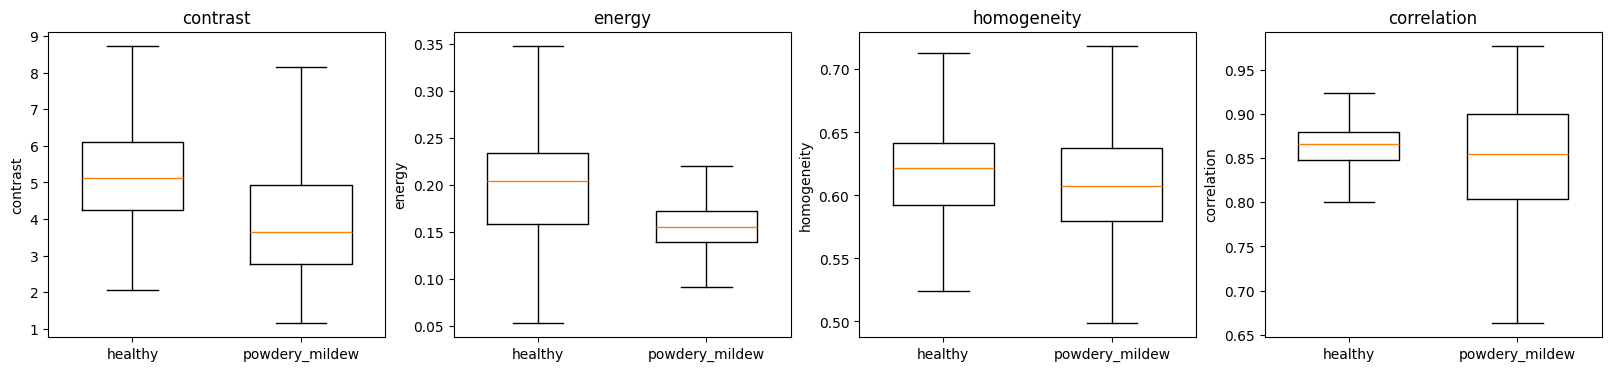

Saved: C:\Users\ksstr\Documents\Coding\milestone-project-5\plots\v2\glcm_boxplots.png


In [16]:
# Boxplots per feature split by class
import matplotlib.pyplot as plt

# Reuse notebook config if available; otherwise set sensible fallbacks
try:
    PLOTS_V2_DIR
except NameError:
    PLOTS_V2_DIR = Path("plots") / "v2"
PLOTS_V2_DIR.mkdir(parents=True, exist_ok=True)

# Load features table if not already in memory
try:
    df_glcm
except NameError:
    df_glcm = pd.read_csv(Path("inputs") / "features" / "v1" / "glcm_features.csv")

# Determine feature columns (exclude non-feature fields)
candidate_exclude = {"label", "filepath", "class", "image", "id"}
FEATURES = [c for c in df_glcm.columns if c not in candidate_exclude]

assert "label" in df_glcm.columns, "Expected 'label' column not found in GLCM features."

# Build a compact grid of boxplots
n_feats = len(FEATURES)
cols = min(4, n_feats)
rows = (n_feats + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.6 * rows), constrained_layout=True)
if not isinstance(axes, (list, np.ndarray)):
    axes = [axes]
axes = axes.flatten()

for ax, feat in zip(axes, FEATURES):
    # Gather data per class
    vals_healthy = df_glcm.loc[df_glcm["label"] == "healthy", feat].dropna()
    vals_mildew  = df_glcm.loc[df_glcm["label"] == "powdery_mildew", feat].dropna()

    ax.boxplot(
        [vals_healthy.values, vals_mildew.values],
        labels=["healthy", "powdery_mildew"],
        showfliers=False,
        widths=0.6,
    )
    ax.set_title(feat)
    ax.set_xlabel("")
    ax.set_ylabel(feat)

# Hide any unused axes
for j in range(len(FEATURES), len(axes)):
    fig.delaxes(axes[j])

out_plot = PLOTS_V2_DIR / "glcm_boxplots.png"
fig.savefig(out_plot, dpi=150, bbox_inches="tight", pad_inches=0.2)
plt.show()
plt.close(fig)
print("Saved:", out_plot.resolve())